In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from numpy.random import Generator, PCG64
import time

In [2]:
class SquareGrid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.walls = []
 
    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height
 
    def passable(self, id):
        return id not in self.walls
 
    def neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: results.reverse()
        results = filter(self.in_bounds, results)
        results = filter(self.passable, results)
        return results

In [3]:
class GridWithWeights(SquareGrid):
    def __init__(self, width, height):
        super().__init__(width, height)
        self.weights = {}
 
    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)


In [4]:
class PriorityQueue:
    def __init__(self):
         self.elements = []
 
    def empty(self):
        return len(self.elements) == 0
 
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
 
    def get(self):
        return heapq.heappop(self.elements)[1]

   

In [5]:
 def heuristic(s, d):
        (x1, y1) = s
        (x2, y2) = d
        return abs(x1 - x2) + abs(y1 - y2)
    
def simulate(graph, start, goal, w=1):
        frontier = PriorityQueue()
        frontier.put(start, 0)
        came_from = {}
        cost_so_far = {}
        came_from[start] = None
        cost_so_far[start] = 0
 
        while not frontier.empty():
            current = frontier.get()
            if current == goal:
                break
            for next in graph.neighbors(current):
                new_cost = cost_so_far[current] + graph.cost(current, next)
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + w * heuristic(goal, next)
                    frontier.put(next, priority)
                    came_from[next] = current
        return came_from, cost_so_far

def generate_grid (m, n, n_obst, l_min, l_max):
        lenght = rs.integers(l_min, l_max, n_obst, dtype=int)
        index = rs.choice(range(m*n), size=n_obst, replace=False)
        x = index//n
        y = index%n
        direct = rs.integers(0, 2, n_obst, dtype=bool)
        directions = np.dstack((direct, ~direct))
        coordinates = np.dstack((x, y))
        walls = []
        for i in range(n_obst):
            for j in range(lenght[i]):
                coord = coordinates[0][i] + directions[0][i]*j
                if coord[0] >= m or coord[1] >= n:
                    continue
                walls.append((coord[0], coord[1]))
        g = GridWithWeights(m, n)
        g.walls = walls
        return g

def draw_grid(grid):
        image = np.full((grid.height, grid.width), np.nan)
        for obst in grid.walls:
            image[obst[0], obst[1]] = 1
        return image

def draw_traject(grid, came_from, goal):
        image = np.full((grid.width, grid.height), np.nan)
        traj = [goal]
        while not (traj[-1] is None):
            traj.append(came_from[traj[-1]]) 
        traj.pop()
        for point in traj:
            image[point[0], point[1]] = 1
        return image, len(traj)

def gen_points_in_area(grid, xlim0, ylim0, xlim1, ylim1):
        P_0 = (rs.integers(ylim0[0], ylim0[1], dtype=int), rs.integers(xlim0[0], xlim0[1], 
dtype=int))
        P_1 = (rs.integers(ylim1[0], ylim1[1], dtype=int), rs.integers(xlim1[0], xlim1[1], 
dtype=int))
        while P_0 in grid.walls:
            P_0 = (rs.integers(ylim0[0], ylim0[1], dtype=int), rs.integers(xlim0[0], xlim0[
1], dtype=int))
        while P_1 in grid.walls:
            P_1 = (rs.integers(ylim1[0], ylim1[1], dtype=int), rs.integers(xlim1[0], xlim1[
1], dtype=int))
        print(f'Координаты точки старта А[{P_0[1]};{P_0[0]}]')
        print(f'Координаты точки финиша В[{P_1[1]};{P_1[0]}]')
        return P_0, P_1

def plot_grid(obstacle, traj, start, goal, lenght):
    %matplotlib inline 
    %config InlineBackend.figure_format = 'svg' 
    rc = {"font.family" : "serif", 
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    fs = 14
    fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=1, tight_layout=True, dpi=300
);
    ax.xaxis.set_ticks_position('top')
    ax.imshow(obstacle, cmap='gray')
    ax.imshow(traj, cmap='brg', vmin=0, vmax=1)
    ax.scatter(start[1], start[0], c='green')
    ax.scatter(goal[1], goal[0], c='red')
    ax.set_title(f'Длина пути: {lenght}', fontsize=fs, pad=10)
    ax.set_xlabel(r'$x$', fontsize = fs)
    ax.set_ylabel(r'$y$', rotation=0, fontsize = fs) 
    plt.show()
 


In [7]:
def launch(m, n, n_obs, obs_len__min, obs_len__max, xlim0, ylim0, xlim1, ylim1, w_max):
    grid = generate_grid(m, n, n_obs, obs_len__min, obs_len__max)
    obstacle = draw_grid(grid)

    start, goal = gen_points_in_area(grid, xlim0, ylim0, xlim1, ylim1)
    execution_time = []
    for w in range(w_max):
        w += 1
        start_time = time.time()
        came_from, cost = simulate(grid, start, goal, w)
        traj, lenght = draw_traject(grid, came_from, goal)
        finish_time = time.time()
        execution_time.append(finish_time - start_time)
        plot_grid(obstacle, traj, start, goal, lenght)
    for i in range(w_max):
        print(f'Время исполнения для w = {i+1}: {execution_time[i]}')

Координаты точки старта А[2;71]
Координаты точки финиша В[94;5]


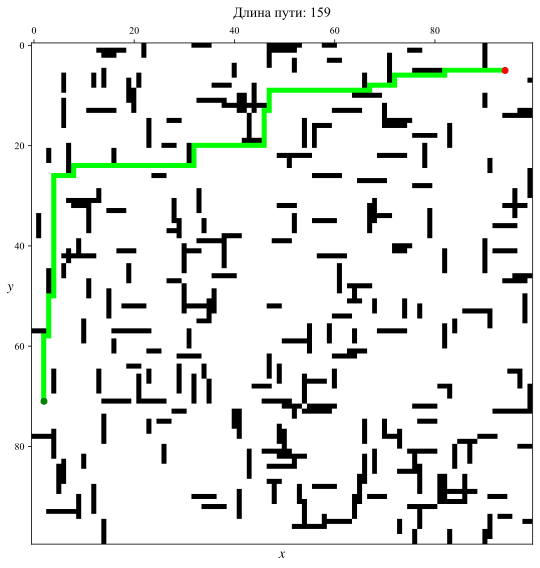

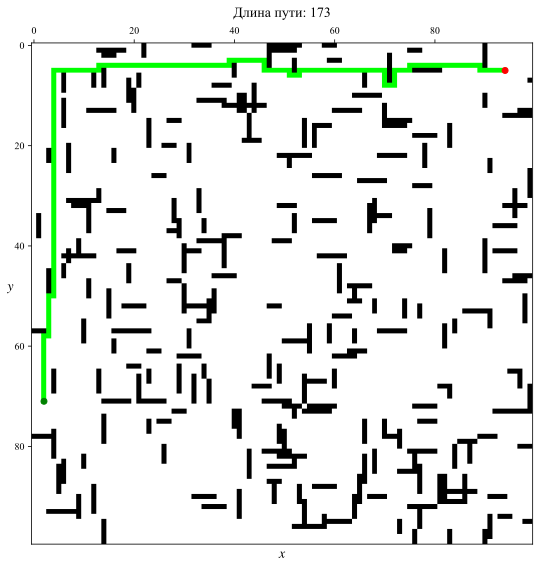

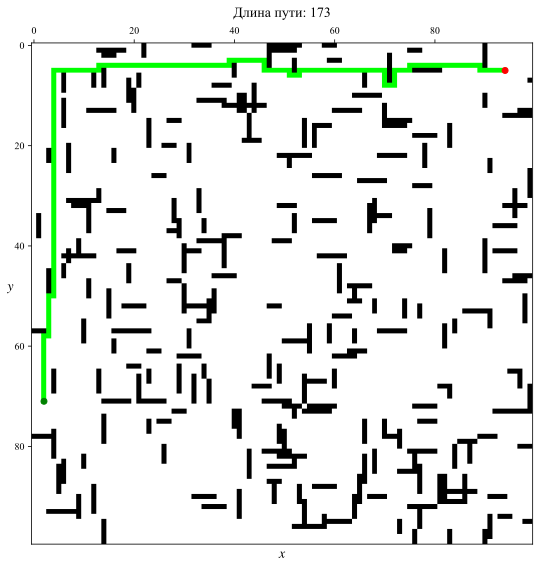

Время исполнения для w = 1: 0.2680063247680664
Время исполнения для w = 2: 0.0855259895324707
Время исполнения для w = 3: 0.06201815605163574


In [8]:
# Размеры (ширина и длина) поля
m, n = 100, 100
# Число препятствий
n_obs = 250
# min и max длины препятствий
obs_len__min, obs_len__max = 3, 7
# Область пространства появления (точки A) и...
xlim0, ylim0 = [0, n // 5], [0, m]
# назначения объекта (точки B)
xlim1, ylim1 = [n - n // 5, n], [0, m]
# Максимальное значение рассматриваемого весового коэффициента
w_max = 3
# Значение для генератора случайных чисел
seed = 8901
rs = Generator(PCG64(seed))
launch(m, n, n_obs, obs_len__min, obs_len__max, xlim0, ylim0, xlim1, ylim1, w_max)